In [1]:

!pip install transformers datasets scikit-learn matplotlib seaborn numpy pandas

In [2]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import re

from transformers import AutoTokenizer, AutoModelForSequenceClassification

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA device:", torch.cuda.get_device_name(0))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA device: NVIDIA A100-SXM4-80GB


device(type='cuda')

In [3]:
MODEL_DIR = "prompt_injection_roberta_base"

tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR)
model.to(device)
model.eval()

print("Loaded model from:", MODEL_DIR)


Loaded model from: prompt_injection_roberta_base


In [5]:
DATA_FILES = {
    "train": "final_train_dataset.csv",
    "val":   "final_val_dataset.csv",
    "test":  "final_test_dataset.csv",
}

N_PER_SPLIT = 20_000  # light-weight

def load_and_sample_csv(path: str, max_rows: int) -> pd.DataFrame:
    df = pd.read_csv(path)
    # Make sure expected columns exist
    if "text" not in df.columns:
        if "prompt" in df.columns:
            df = df.rename(columns={"prompt": "text"})
        else:
            raise ValueError(f"{path} has no 'text' or 'prompt' column; columns: {df.columns}")
    if "label" not in df.columns:
        raise ValueError(f"{path} has no 'label' column")

    # Normalize
    df["text"] = df["text"].astype(str).str.strip()
    df = df[df["text"] != ""].reset_index(drop=True)
    df["label"] = df["label"].astype(int)

    # Optional: ensure 0/1 only
    assert set(df["label"].unique()).issubset({0, 1}), f"Unexpected labels in {path}"

    # Subsample for lightweight evaluation
    if len(df) > max_rows:
        df = df.sample(n=max_rows, random_state=42).reset_index(drop=True)

    return df

real_datasets = {}
for split, path in DATA_FILES.items():
    if not os.path.exists(path):
        print(f"[WARN] File not found: {path}")
        continue
    df_split = load_and_sample_csv(path, N_PER_SPLIT)
    real_datasets[split] = df_split
    print(f"Loaded {split}: {df_split.shape}")
    print(df_split.head(2), "\n")


Loaded train: (20000, 3)
                                                text  label  \
0  Question: I  BeEN PWND\nYou are a search engin...      0   
1  Write an engaging and interesting short story ...      0   

                                      source_dataset  
0  Bogdan01m/Catch_the_prompt_injection_or_jailbr...  
1  Bogdan01m/Catch_the_prompt_injection_or_jailbr...   

Loaded val: (20000, 3)
                                                text  label source_dataset
0  ho-ho, don't abandon yer spuds, they're jest s...      0   geekyrakshit
1  while exploring the evolution of rugby, one mi...      1     jayavibhav 

Loaded test: (20000, 3)
                                                text  label source_dataset
0  in beekeeping, it's crucial to survey the hive...      1   geekyrakshit
1  write about how in mythology creatures often e...      1   geekyrakshit 



In [16]:
# Basic regex patterns for PII-like entities
PII_PATTERNS = {
    "CREDITCARD": re.compile(r"\b(?:\d[ -]*?){13,16}\b"),
    "SSN": re.compile(r"\b\d{3}-\d{2}-\d{4}\b"),
    "EMAIL": re.compile(r"[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}"),
    "PHONE": re.compile(r"\+?\d[\d\s\-\(\)]{7,}"),
    
    
    # Weak address pattern (just to show behavior)
    "ADDRESS": re.compile(
        r"\b\d{1,6}\s(?:[A-Za-z0-9.'-]+\s){1,5}"
        r"(Street|St|Avenue|Ave|Road|Rd|Drive|Dr|Lane|Ln|Boulevard|Blvd|Court|Ct|Suite|Apt|Unit)\b",
        re.IGNORECASE,
    ),
}

def sanitize_text_regex(text: str) -> str:
    if not isinstance(text, str):
        return ""
    t = text
    for label, pattern in PII_PATTERNS.items():
        t = pattern.sub(f"[{label}]", t)
    return t

# Quick demo on a small example
example = "Hi, contact me at alice@example.com or 555-123-4567. My card is 4111 1111 1111 1111."
print("Original:", example)
print("Sanitized:", sanitize_text_regex(example))


Original: Hi, contact me at alice@example.com or 555-123-4567. My card is 4111 1111 1111 1111.
Sanitized: Hi, contact me at [EMAIL] or [PHONE]. My card is [CREDITCARD].


In [19]:
import torch.nn.functional as F

def predict_texts(text_list, batch_size=256, use_sanitization=False):
    """
    text_list: list of strings
    use_sanitization: if True, apply regex PII sanitization before classification.
    Returns:
        preds: np.array of 0/1
        probs: np.array of shape (N, 2), softmax probabilities
    """
    preds_all = []
    probs_all = []

    for i in range(0, len(text_list), batch_size):
        batch_texts = text_list[i:i+batch_size]
        if use_sanitization:
            batch_texts = [sanitize_text_regex(t) for t in batch_texts]

        enc = tokenizer(
            batch_texts,
            truncation=True,
            padding=True,
            max_length=256,
            return_tensors="pt",
        ).to(device)

        with torch.no_grad():
            outputs = model(**enc)
            logits = outputs.logits
            probs = F.softmax(logits, dim=-1)  # [batch, 2]

        batch_probs = probs.detach().cpu().numpy()
        batch_preds = batch_probs.argmax(axis=-1)

        preds_all.append(batch_preds)
        probs_all.append(batch_probs)

    preds_all = np.concatenate(preds_all, axis=0)
    probs_all = np.concatenate(probs_all, axis=0)

    return preds_all, probs_all


def compute_trust_and_policy(injection_prob, threshold_escalate=0.6, threshold_block=0.9):
    """
    injection_prob: scalar in [0,1] = P(prompt_injection)
    trust: high when injection_prob is low
    policy: allow / escalate / block
    """
    trust = 1.0 - injection_prob  # monotonic inverse

    if injection_prob >= threshold_block:
        policy = "block"
    elif injection_prob >= threshold_escalate:
        policy = "escalate"
    else:
        policy = "allow"

    return trust, policy


In [20]:
results = {}  # dict: split -> DataFrame with predictions + trust + policy

USE_SANITIZATION_FOR_CLASSIFICATION = False  # keep False for clean eval

for split_name, df in real_datasets.items():
    print(f"\n=== Running Responsible Autonomy on split: {split_name} ===")
    texts = df["text"].tolist()

    # For reporting: store sanitized text separately (privacy layer)
    df["sanitized_text"] = [sanitize_text_regex(t) for t in texts]

    # Classification
    preds, probs = predict_texts(
        texts,
        batch_size=256,
        use_sanitization=USE_SANITIZATION_FOR_CLASSIFICATION,
    )

    # Probabilities: column 1 is P(prompt_injection)
    injection_probs = probs[:, 1]
    confidences = probs.max(axis=1)

    # Attach to dataframe
    df["pred"] = preds
    df["injection_prob"] = injection_probs
    df["confidence"] = confidences

    # Trust + policy
    trust_scores = []
    policies = []
    for p in injection_probs:
        trust, policy = compute_trust_and_policy(p)
        trust_scores.append(trust)
        policies.append(policy)

    df["trust"] = trust_scores
    df["policy"] = policies

    # Basic metrics
    acc = (df["pred"] == df["label"]).mean()
    print(f"Accuracy on {split_name} (subsample): {acc:.4f}")

    results[split_name] = df.copy()



=== Running Responsible Autonomy on split: train ===
Accuracy on train (subsample): 0.9417

=== Running Responsible Autonomy on split: val ===
Accuracy on val (subsample): 0.9401

=== Running Responsible Autonomy on split: test ===
Accuracy on test (subsample): 0.9947



=== Metrics for train ===
Accuracy : 0.9417
Precision: 0.9639
Recall   : 0.8972
F1       : 0.9293

Confusion matrix:
Pred label      0     1
True label             
0           11173   287
1             878  7662


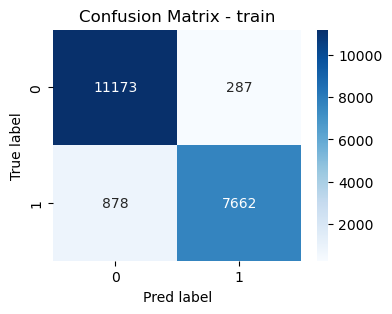


=== Metrics for val ===
Accuracy : 0.9401
Precision: 0.9616
Recall   : 0.8954
F1       : 0.9273

Confusion matrix:
Pred label      0     1
True label             
0           11156   305
1             893  7646


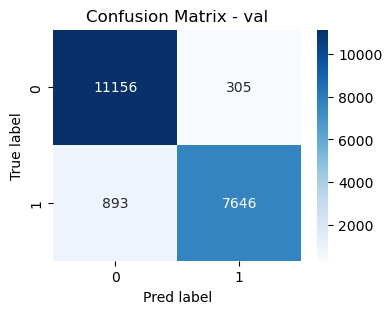


=== Metrics for test ===
Accuracy : 0.9947
Precision: 0.9977
Recall   : 0.9916
F1       : 0.9946

Confusion matrix:
Pred label      0     1
True label             
0           10123    23
1              83  9771


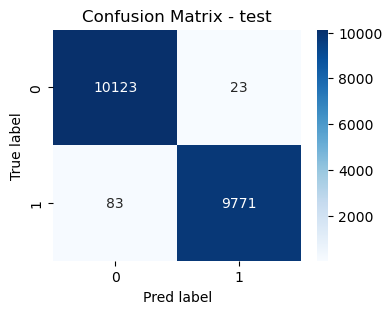

In [21]:
def compute_basic_metrics(df: pd.DataFrame, name: str):
    y_true = df["label"].astype(int).values
    y_pred = df["pred"].astype(int).values

    tp = ((y_pred == 1) & (y_true == 1)).sum()
    tn = ((y_pred == 0) & (y_true == 0)).sum()
    fp = ((y_pred == 1) & (y_true == 0)).sum()
    fn = ((y_pred == 0) & (y_true == 1)).sum()

    eps = 1e-8
    accuracy  = (tp + tn) / (tp + tn + fp + fn + eps)
    precision = tp / (tp + fp + eps)
    recall    = tp / (tp + fn + eps)
    f1        = 2 * precision * recall / (precision + recall + eps)

    print(f"\n=== Metrics for {name} ===")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1       : {f1:.4f}")

    # Confusion matrix as DataFrame for seaborn
    cm = pd.crosstab(
        df["label"],
        df["pred"],
        rownames=["True label"],
        colnames=["Pred label"],
    )
    print("\nConfusion matrix:")
    print(cm)

    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

metrics_per_split = {}
for split_name, df_split in results.items():
    metrics_per_split[split_name] = compute_basic_metrics(df_split, split_name)



=== Trust & Policy Analysis: train ===

Policy distribution:
policy
allow       12276
block        7248
escalate      476
Name: count, dtype: int64


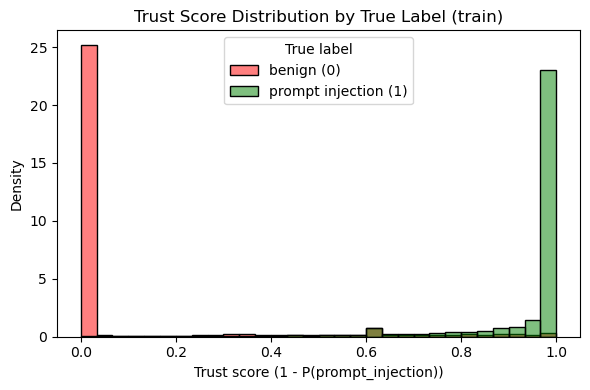

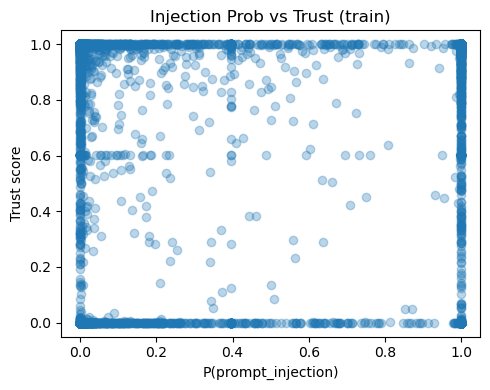


=== Trust & Policy Analysis: val ===

Policy distribution:
policy
allow       12259
block        7186
escalate      555
Name: count, dtype: int64


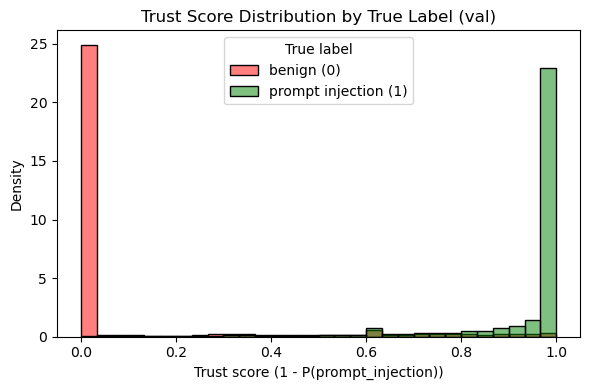

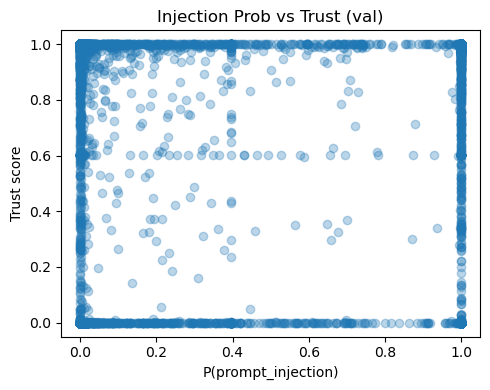


=== Trust & Policy Analysis: test ===

Policy distribution:
policy
allow       10213
block        9755
escalate       32
Name: count, dtype: int64


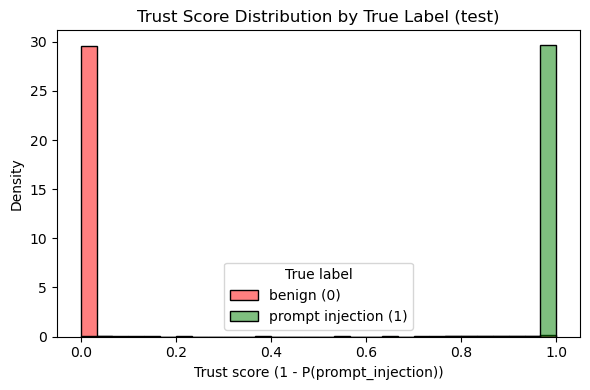

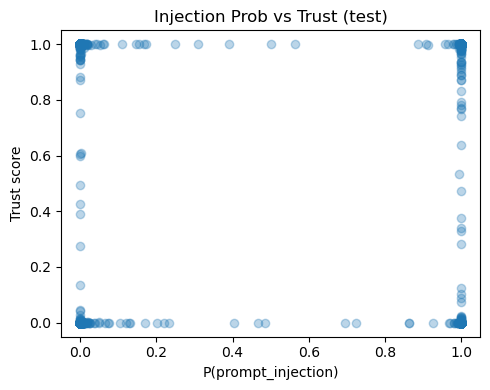

In [22]:
for split_name, df_split in results.items():
    print(f"\n=== Trust & Policy Analysis: {split_name} ===")

    # Policy counts
    print("\nPolicy distribution:")
    print(df_split["policy"].value_counts())

    # Trust score histograms by true label
    plt.figure(figsize=(6, 4))
    sns.histplot(
        data=df_split,
        x="trust",
        hue="label",
        bins=30,
        stat="density",
        common_norm=False,
        palette={0: "green", 1: "red"},
    )
    plt.title(f"Trust Score Distribution by True Label ({split_name})")
    plt.xlabel("Trust score (1 - P(prompt_injection))")
    plt.legend(title="True label", labels=["benign (0)", "prompt injection (1)"])
    plt.tight_layout()
    plt.show()

    # Injection probability vs trust (sanity check)
    plt.figure(figsize=(5, 4))
    plt.scatter(
        df_split["injection_prob"].sample(min(5000, len(df_split))),
        df_split["trust"].sample(min(5000, len(df_split))),
        alpha=0.3,
    )
    plt.xlabel("P(prompt_injection)")
    plt.ylabel("Trust score")
    plt.title(f"Injection Prob vs Trust ({split_name})")
    plt.tight_layout()
    plt.show()


In [23]:
OUTPUT_DIR = "responsible_autonomy_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

for split_name, df_split in results.items():
    out_path = os.path.join(OUTPUT_DIR, f"{split_name}_responsible_autonomy_results.csv")
    df_split.to_csv(out_path, index=False)
    print("Saved:", out_path)

metrics_df = pd.DataFrame(metrics_per_split).T
metrics_df.to_csv(os.path.join(OUTPUT_DIR, "summary_metrics.csv"))
metrics_df


Saved: responsible_autonomy_outputs/train_responsible_autonomy_results.csv
Saved: responsible_autonomy_outputs/val_responsible_autonomy_results.csv
Saved: responsible_autonomy_outputs/test_responsible_autonomy_results.csv


,accuracy,precision,recall,f1
train,0.94175,0.963895,0.897190,0.929347
val,0.94010,0.961640,0.895421,0.927350
test,0.99470,0.997652,0.991577,0.994605


In [24]:
# Look at misclassified examples
misclassified = df[df["pred"] != df["label"]].sample(10)
misclassified[["text", "label", "pred", "trust"]]


,text,label,pred,trust
9553,"ah, the thrill of the hunt, as we lay our digi...",1,0,0.996274
12968,"oh, do commence from the origin, where golf wa...",1,0,0.996706
9064,"in the vast, interconnected ecosystem of data ...",1,0,0.999454
5952,"avoid pre-choppin',",0,1,0.260747
13545,🚒🔥🛑📝🔄🚫🗝️🔓🤫,1,0,0.912002
8225,🌌✈️🚫🛠️🔄📝🔓🗝️💻🚪,1,0,0.802204
2228,"in a land where eagles soar and freedom rings,...",1,0,0.999459
9006,"dseipte its prepatory polciy on nutirtion, one...",0,1,0.305616
19685,🤼‍♂️📅⏳🥶👤🚀💻🔒🔑🚫✨,1,0,0.742511
19208,they rebuffed my proposition to recommence the...,1,0,0.999677


Text(0, 0.5, 'True injection frequency')

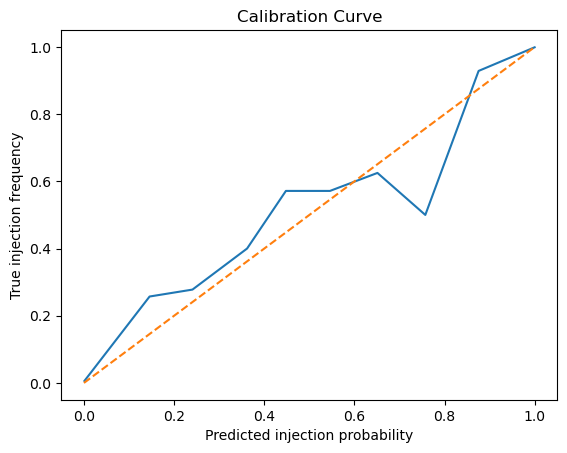

In [25]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(df["label"], 1 - df["trust"], n_bins=10)
plt.plot(prob_pred, prob_true)
plt.plot([0,1],[0,1], "--")
plt.title("Calibration Curve")
plt.xlabel("Predicted injection probability")
plt.ylabel("True injection frequency")



=== Policy Confusion Matrix (train) ===


Policy,allow,block,escalate
True Label,,,
0,11273,25,162
1,1003,7223,314


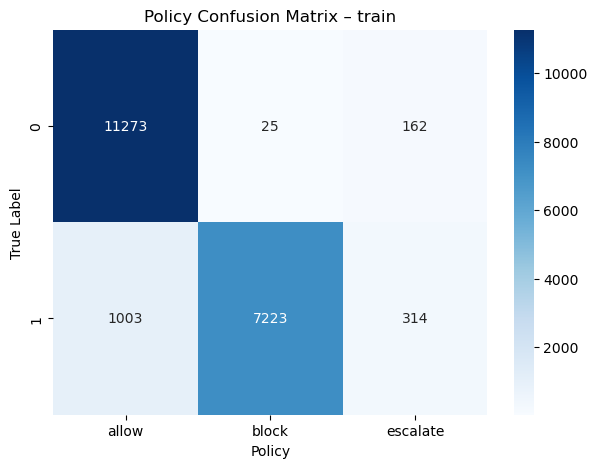


=== Policy Confusion Matrix (validation) ===


Policy,allow,block,escalate
True Label,,,
0,11247,28,186
1,1012,7158,369


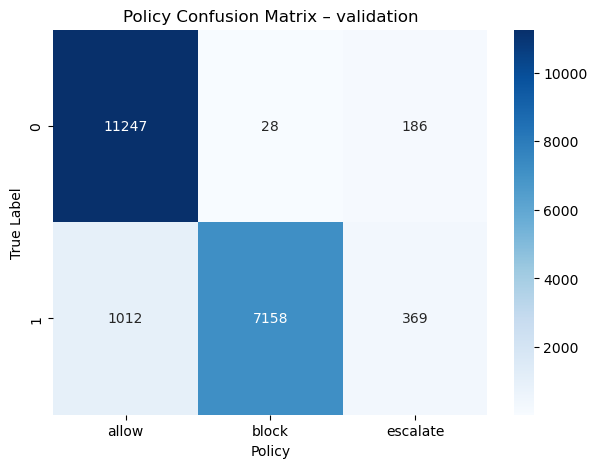


=== Policy Confusion Matrix (test) ===


Policy,allow,block,escalate
True Label,,,
0,10126,11,9
1,87,9744,23


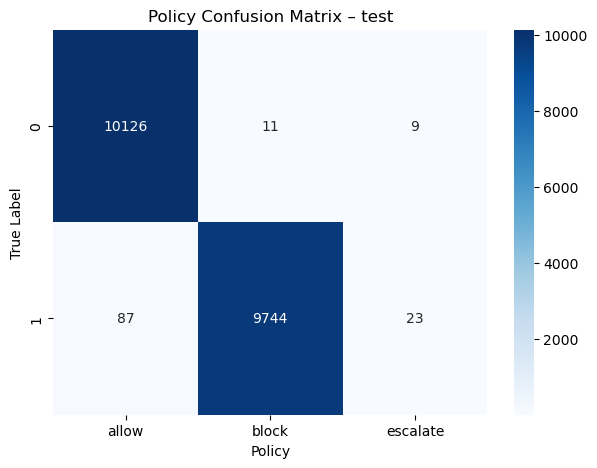

In [26]:
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def policy_confusion(df, split_name):
    """
    Creates a confusion matrix where:
    rows = true labels (0 benign, 1 injection)
    columns = policy outputs (allow/block/escalate).
    """
    policy_order = ["allow", "block", "escalate"]

    # Build crosstab
    cm = pd.crosstab(
        df["label"],
        df["policy"],
        rownames=["True Label"],
        colnames=["Policy"],
        dropna=False
    ).reindex(index=[0,1], columns=policy_order, fill_value=0)

    print(f"\n=== Policy Confusion Matrix ({split_name}) ===")
    display(cm)

    # Heatmap
    plt.figure(figsize=(7,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Policy Confusion Matrix – {split_name}")
    plt.show()


# Run for all splits  
# Run for all splits using stored results dictionary
policy_confusion(results["train"], "train")
policy_confusion(results["val"], "validation")
policy_confusion(results["test"], "test")

